In [26]:
import re
import pandas as pd
import numpy as np
import sacrebleu
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


# A dictionary to hold our data: {sentence_id: {"ref": "...", "hypo": "..."}}
translations = {}

# The file generated by `fairseq-generate`
input_file = "eval_99.txt"


In [27]:

with open(input_file, 'r', encoding='utf-8') as f:
    for line in f:
        # We only care about the detokenized hypothesis (D) and target (T)
        if line.startswith('T-'):
            parts = line.strip().split('\t')
            sent_id = parts[0].split('-')[1]
            if sent_id not in translations:
                translations[sent_id] = {}
            translations[sent_id]['ref'] = parts[1]

        elif line.startswith('D-'):
            parts = line.strip().split('\t')
            sent_id = parts[0].split('-')[1]
            if sent_id not in translations:
                translations[sent_id] = {}
            # We use the score from the D- line, and the text
            translations[sent_id]['score'] = float(parts[1])
            translations[sent_id]['hypo'] = parts[2]


In [28]:
print(translations['175'])

{'ref': 'System Calls', 'score': -0.8487561345100403, 'hypo': 'System call'}


In [29]:

# Now, iterate through the collected sentences and calculate detailed BLEU
# Remember the user instruction: 1-indexing for math, 0 for programming
# We will sort by sentence ID for ordered output
for sent_id in sorted(translations.keys(), key=int):
    data = translations[sent_id]

    # Ensure we have both a hypothesis and a reference
    if 'hypo' not in data or 'ref' not in data:
        continue

    hypo = data['hypo']
    ref = data['ref']

    # Use sacrebleu to calculate sentence-level BLEU and precisions
    # The .precisions attribute is a list of [P1, P2, P3, P4]
    bleu_stats = sacrebleu.sentence_bleu(hypo, [ref])

    # Format the precisions for printing
    precisions_str = "/".join([f"{p:.1f}" for p in bleu_stats.precisions])

    # The user asked for 1-based indexing in mathematical notation.
    # We will present the sentence ID as-is from the file.
    print(f"Sentence-{sent_id}\tBLEU: {bleu_stats.score:.2f}\tPrecisions: {precisions_str}")

Sentence-0	BLEU: 42.73	Precisions: 80.0/50.0/33.3/25.0
Sentence-1	BLEU: 44.23	Precisions: 76.7/58.6/42.9/29.6
Sentence-2	BLEU: 100.00	Precisions: 100.0/100.0/0.0/0.0
Sentence-3	BLEU: 55.03	Precisions: 66.7/50.0/50.0/0.0
Sentence-4	BLEU: 55.03	Precisions: 66.7/50.0/50.0/0.0
Sentence-5	BLEU: 50.00	Precisions: 50.0/50.0/0.0/0.0
Sentence-6	BLEU: 50.00	Precisions: 50.0/50.0/0.0/0.0
Sentence-7	BLEU: 100.00	Precisions: 100.0/0.0/0.0/0.0
Sentence-8	BLEU: 100.00	Precisions: 100.0/100.0/100.0/100.0
Sentence-9	BLEU: 10.40	Precisions: 40.0/12.5/8.3/6.2
Sentence-10	BLEU: 58.64	Precisions: 85.7/69.2/58.3/45.5
Sentence-11	BLEU: 27.53	Precisions: 75.0/33.3/25.0/25.0
Sentence-12	BLEU: 60.29	Precisions: 80.0/63.2/55.6/47.1
Sentence-13	BLEU: 55.03	Precisions: 66.7/50.0/50.0/0.0
Sentence-14	BLEU: 0.00	Precisions: 0.0/0.0/0.0/0.0
Sentence-15	BLEU: 52.21	Precisions: 80.0/63.6/48.8/35.7
Sentence-16	BLEU: 55.03	Precisions: 66.7/50.0/50.0/0.0
Sentence-17	BLEU: 37.99	Precisions: 83.3/60.0/25.0/16.7
Sentence-18	

In [30]:
import re
import pandas as pd
import numpy as np
import sacrebleu
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# --- Step 1: Extract relevant data from the log file (First-Beam Only) ---

# The file generated by `fairseq-generate`
input_file = "inference_output90_1.txt"

# Dictionaries to hold our parsed data
diag_stats = defaultdict(lambda: {"fraction_old": [], "prob_mass_old": []})
translations = {}

# Regex patterns to find the different lines
batch_start_pattern = re.compile(r"sent ids of batch:")
diag_pattern = re.compile(r"DIAG_SENT,(\d+),fraction_old=([\d.]+),prob_mass_old=([\d.]+)")
target_pattern = re.compile(r"^T-(\d+)\s(.*)")
hypo_pattern = re.compile(r"^D-(\d+)\s-?[\d.]+\s(.*)")

# This set will be reset for each batch to track sentences we've already processed.
processed_sents_in_batch = set()

print("Starting to parse the log file...")
with open(input_file, 'r', encoding='utf-8') as f:
    for line in f:
        # If we see the start of a new batch, we clear our tracker.
        if batch_start_pattern.search(line):
            processed_sents_in_batch.clear()
            continue

        diag_match = diag_pattern.match(line)
        if diag_match:
            sent_id, frac, prob = diag_match.groups()
            # We only record the stats if we haven't seen this sentence ID in this batch yet.
            if sent_id not in processed_sents_in_batch:
                diag_stats[sent_id]["fraction_old"].append(float(frac))
                diag_stats[sent_id]["prob_mass_old"].append(float(prob))
                # Add the sent_id to our tracker for this batch.
                processed_sents_in_batch.add(sent_id)
            continue

        target_match = target_pattern.match(line)
        if target_match:
            sent_id, text = target_match.groups()
            if sent_id not in translations:
                translations[sent_id] = {}
            translations[sent_id]['ref'] = text
            continue

        hypo_match = hypo_pattern.match(line)
        if hypo_match:
            sent_id, text = hypo_match.groups()
            if sent_id not in translations:
                translations[sent_id] = {}
            translations[sent_id]['hypo'] = text
            continue

print(f"Found diagnostic stats for {len(diag_stats)} unique sentences.")
print(f"Found translations for {len(translations)} unique sentences.")

Starting to parse the log file...
Found diagnostic stats for 2000 unique sentences.
Found translations for 2000 unique sentences.


In [31]:
print(diag_stats['175'])

{'fraction_old': [0.0, 0.0, 0.1111, 0.1111, 0.1111], 'prob_mass_old': [0.0, 0.0, 0.5352, 0.5854, 0.0278]}


In [32]:

avg_diag_stats = {}
for sent_id, data in diag_stats.items():
    avg_diag_stats[sent_id] = {
        "avg_fraction_old": np.mean(data["fraction_old"]) if data["fraction_old"] else 0,
        "avg_prob_mass_old": np.mean(data["prob_mass_old"]) if data["prob_mass_old"] else 0,
    }


In [33]:
# --- Step 3: Combine BLEU stats and diagnostic stats in a Pandas DataFrame ---

analysis_data = []
for sent_id, trans in translations.items():
    if sent_id not in avg_diag_stats:
        continue  # Skip if there's no diagnostic data for this sentence

    if 'hypo' in trans and 'ref' in trans:
        # Calculate sentence-level BLEU score and precisions
        bleu = sacrebleu.sentence_bleu(trans['hypo'], [trans['ref']])

        # Remembering our previous discussion, I'm fetching the 1-indexed n-gram precisions
        # for our 0-indexed programming environment.
        precisions = bleu.precisions

        record = {
            "sent_id": int(sent_id),
            "ref": trans['ref'],
            "hypo": trans['hypo'],
            "bleu_score": bleu.score,
            "p1": precisions[0], # 1-gram precision
            "p2": precisions[1], # 2-gram precision
            "p3": precisions[2], # 3-gram precision
            "p4": precisions[3], # 4-gram precision
            "avg_fraction_old": avg_diag_stats[sent_id]["avg_fraction_old"],
            "avg_prob_mass_old": avg_diag_stats[sent_id]["avg_prob_mass_old"],
        }
        analysis_data.append(record)

# Create the DataFrame
df = pd.DataFrame(analysis_data)
print("\n--- Analysis DataFrame ---")
display(df)



--- Analysis DataFrame ---


,sent_id,ref,hypo,bleu_score,p1,p2,p3,p4,avg_fraction_old,avg_prob_mass_old
0,175,System Calls,System calls,5.000000e+01,50.000000,50.000000,0.000000,0.000000,0.066660,0.229680
1,581,Conflicts,Collides with,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.040000,0.200000
2,520,Direction Chooser,Direction selection,5.000000e+01,50.000000,50.000000,0.000000,0.000000,0.044440,0.211420
3,484,Use Preferred,Prefer,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.164125,0.450375
4,477,Booleans,Boolean Type,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.204440,0.200000
...,...,...,...,...,...,...,...,...,...,...
1995,313,"? php mysql _ connect (""localhost"", ""mysql _ u...","? php mysql _ connect (""localhost,"" ""mysql _ u...",6.458822e+01,99.009901,91.000000,80.808081,72.448980,0.775344,0.667866
1996,1265,Another feature of & kgeography; is the possib...,"In & kgeography;, you can zoom in on an area o...",9.536972e+00,68.478261,27.472527,11.111111,1.123596,0.093766,0.119967
1997,458,Vorbis' audio quality is not best measured in ...,Vorbis' audio quality is,6.560200e-10,100.000000,100.000000,100.000000,100.000000,0.188015,0.156634
1998,559,Thanks to the action concept of & Qt; and & kd...,The & Qt; and & kde; Image Plugin can be used ...,1.315632e+01,62.857143,31.884058,20.588235,11.940299,0.143411,0.067956


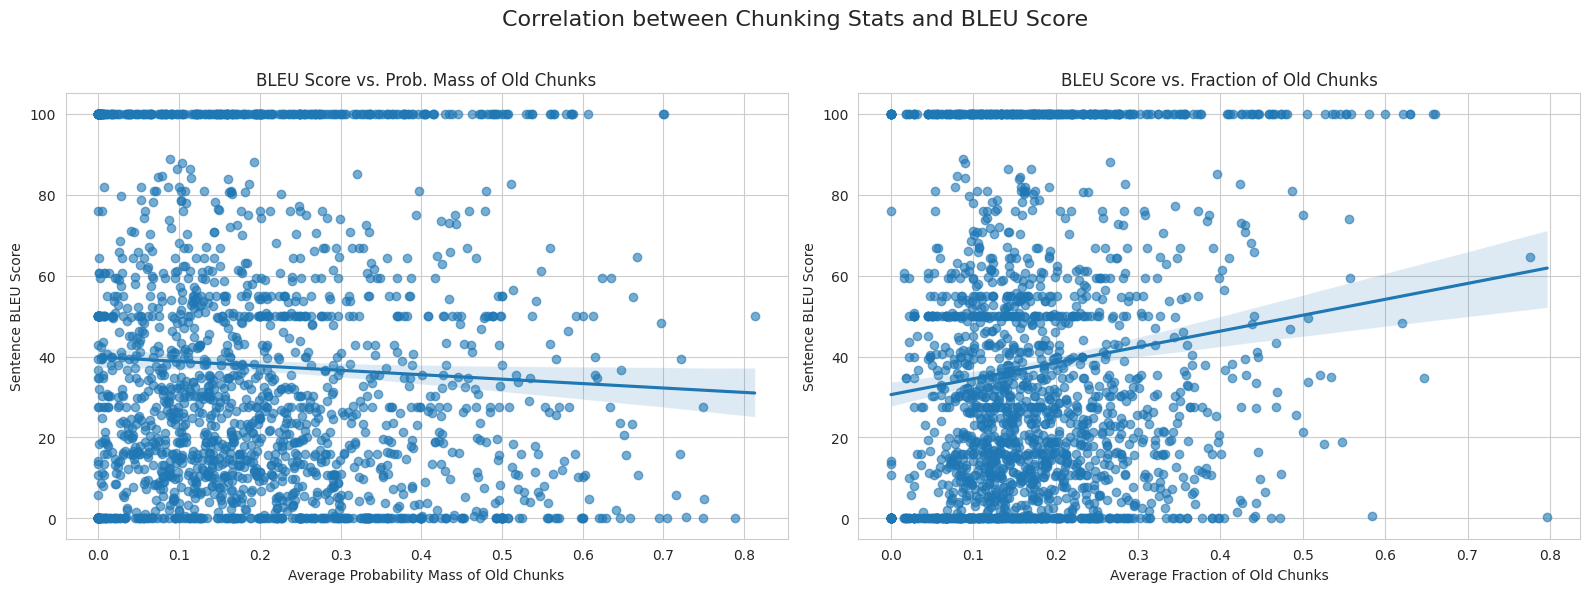

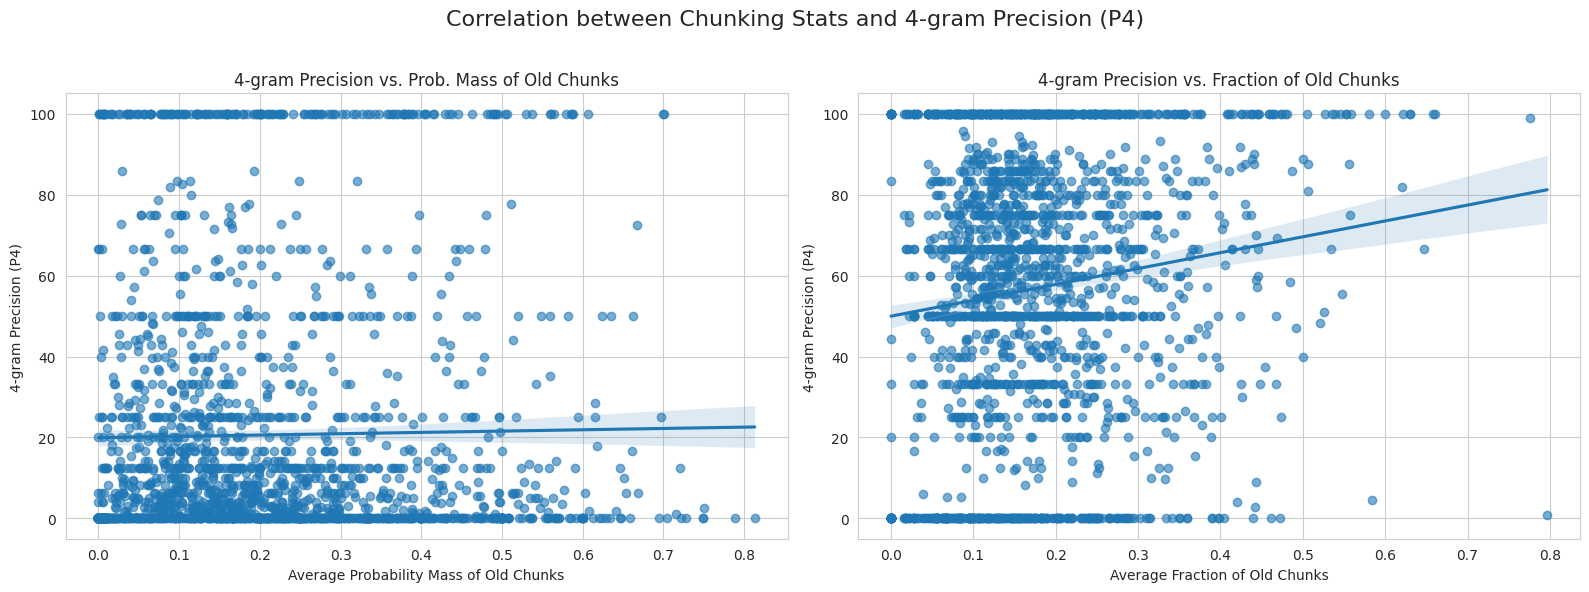

In [34]:


# --- Step 4: Chart the data as scatterplots to find correlations ---

# Set plot style
sns.set_style("whitegrid")

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Correlation between Chunking Stats and BLEU Score', fontsize=16)

# Plot 1: BLEU vs. Average Probability Mass of Old Chunks
sns.regplot(
    ax=axes[0],
    data=df,
    x="avg_prob_mass_old",
    y="bleu_score",
    scatter_kws={'alpha':0.6}
)
axes[0].set_title("BLEU Score vs. Prob. Mass of Old Chunks")
axes[0].set_xlabel("Average Probability Mass of Old Chunks")
axes[0].set_ylabel("Sentence BLEU Score")

# Plot 2: BLEU vs. Average Fraction of Old Chunks
sns.regplot(
    ax=axes[1],
    data=df,
    x="avg_fraction_old",
    y="bleu_score",
    scatter_kws={'alpha':0.6}
)
axes[1].set_title("BLEU Score vs. Fraction of Old Chunks")
axes[1].set_xlabel("Average Fraction of Old Chunks")
axes[1].set_ylabel("Sentence BLEU Score")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# You can also create plots for n-gram precisions, for example P4
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Correlation between Chunking Stats and 4-gram Precision (P4)', fontsize=16)

sns.regplot(ax=axes[0], data=df, x="avg_prob_mass_old", y="p4", scatter_kws={'alpha':0.6})
axes[0].set_title("4-gram Precision vs. Prob. Mass of Old Chunks")
axes[0].set_xlabel("Average Probability Mass of Old Chunks")
axes[0].set_ylabel("4-gram Precision (P4)")

sns.regplot(ax=axes[1], data=df, x="avg_fraction_old", y="p1", scatter_kws={'alpha':0.6})
axes[1].set_title("4-gram Precision vs. Fraction of Old Chunks")
axes[1].set_xlabel("Average Fraction of Old Chunks")
axes[1].set_ylabel("4-gram Precision (P4)")


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

--- Analysis Binned by Probability Mass of Old Chunks ---
                    mean  count        std
prob_mass_bin                             
(-0.1, 0.0]    31.599371     72  42.077674
(0.0, 0.1]     40.196637    511  33.134974
(0.1, 0.2]     38.692467    536  31.501964
(0.2, 0.4]     35.813467    617  33.738468
(0.4, 0.813]   36.280482    264  34.839537


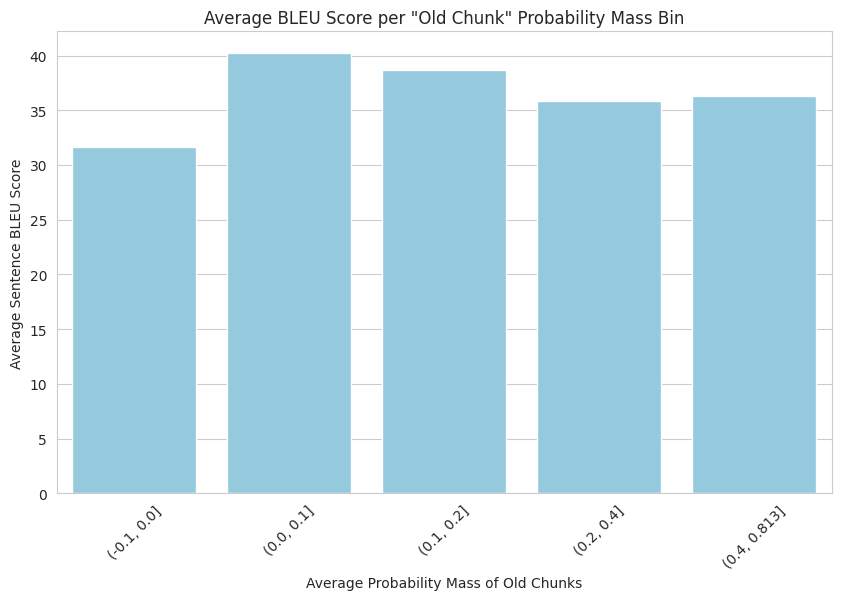

In [35]:
# Assume your DataFrame 'df' from the previous step is available

# 1. Create bins for 'avg_prob_mass_old'
# We define custom bin edges because the data is skewed to the left.
prob_mass_bins = [-0.1, 0.0, 0.1, 0.2, 0.4, df['avg_prob_mass_old'].max()]
df['prob_mass_bin'] = pd.cut(df['avg_prob_mass_old'], bins=prob_mass_bins, right=True)

# 2. Group by these new bins and calculate the mean of the metrics we care about
binned_analysis = df.groupby('prob_mass_bin')['bleu_score'].agg(['mean', 'count', 'std'])

print("--- Analysis Binned by Probability Mass of Old Chunks ---")
print(binned_analysis)

# 3. Visualize the result with a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=binned_analysis.index, y=binned_analysis['mean'], color='skyblue')
plt.title('Average BLEU Score per "Old Chunk" Probability Mass Bin')
plt.xlabel('Average Probability Mass of Old Chunks')
plt.ylabel('Average Sentence BLEU Score')
plt.xticks(rotation=45)
plt.show()

Original dataset size: 2000
Filtered (in-between) dataset size: 1402


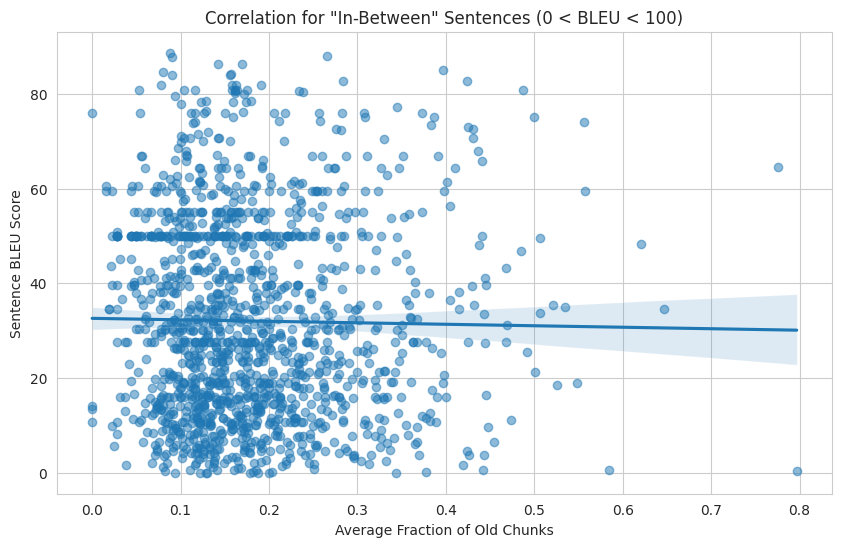

In [36]:
# Create a new DataFrame containing only the "in-between" results
df_filtered = df[(df['bleu_score'] > 0) & (df['bleu_score'] < 100)]

print(f"Original dataset size: {len(df)}")
print(f"Filtered (in-between) dataset size: {len(df_filtered)}")

# Now, re-run the scatter plot from before, but only on the filtered data
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_filtered,
    x='avg_fraction_old',
    y='bleu_score',
    scatter_kws={'alpha': 0.5}
)
plt.title('Correlation for "In-Between" Sentences (0 < BLEU < 100)')
plt.xlabel('Average Fraction of Old Chunks')
plt.ylabel('Sentence BLEU Score')
plt.show()

--- Spearman Rank Correlation Matrix ---
                   bleu_score        p4  avg_prob_mass_old  avg_fraction_old
bleu_score           1.000000  0.468580          -0.058028          0.102085
p4                   0.468580  1.000000           0.012187          0.215532
avg_prob_mass_old   -0.058028  0.012187           1.000000          0.571415
avg_fraction_old     0.102085  0.215532           0.571415          1.000000


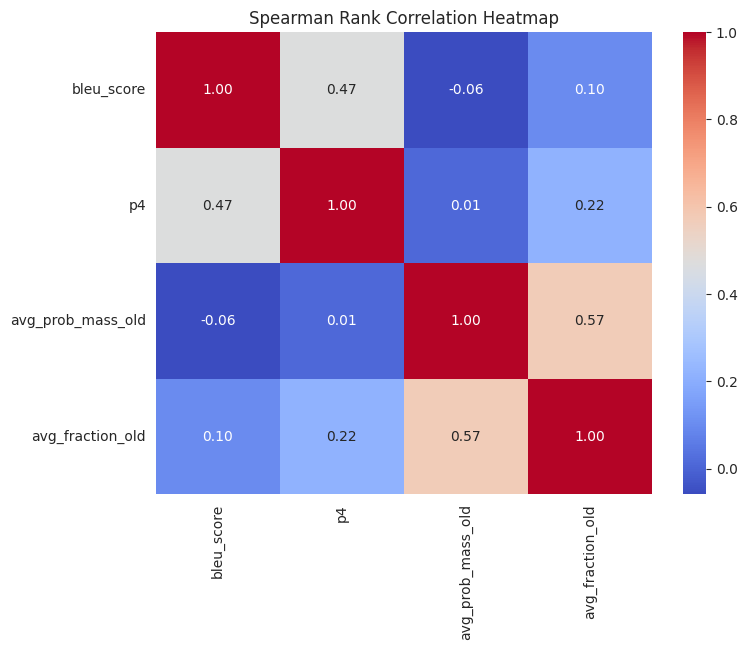

In [37]:
# Calculate Spearman's rank correlation
spearman_corr = df[['bleu_score', 'p4', 'avg_prob_mass_old', 'avg_fraction_old']].corr(method='spearman')

print("--- Spearman Rank Correlation Matrix ---")
print(spearman_corr)

# Visualize it as a heatmap for quick insights
plt.figure(figsize=(8, 6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Rank Correlation Heatmap")
plt.show()